Get dataframe

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../song_features.csv')
df.head()

,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genres
0,1hHGUdFaiJHw9hVZGJWYO2,0.209000,0.585,0.532,0.007970,7,0.2270,-9.673,1,0.0268,94.461,4,0.680,j-rock
1,72cQFFOzx6rw9lgVtCUi17,0.000968,0.434,0.946,0.002760,4,0.1150,-6.588,1,0.1130,185.958,4,0.516,j-rock
2,05NYcsjJwOYq4jIiKPVj9p,0.002570,0.599,0.790,0.001810,4,0.3120,-3.580,1,0.0430,103.783,4,0.961,j-rock
3,6AQFL8Yt5FlMCX8pO3O7KR,0.000010,0.340,0.629,0.865000,1,0.0929,-6.911,0,0.0552,147.286,4,0.251,j-rock
4,6k0X05danQOXSBTVek5DU1,0.000056,0.459,0.878,0.000307,5,0.3710,-1.399,0,0.0688,144.852,4,0.494,j-rock


Heatmap to discover low correlation features

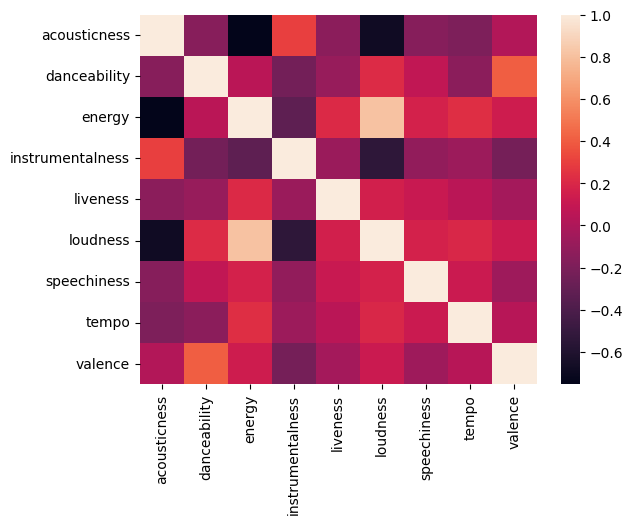

In [9]:
import seaborn as sns
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
dataplot = sns.heatmap(df[features].corr())
plt.show()

Investigate the relationship between energy and loudness since it has the highest correlation

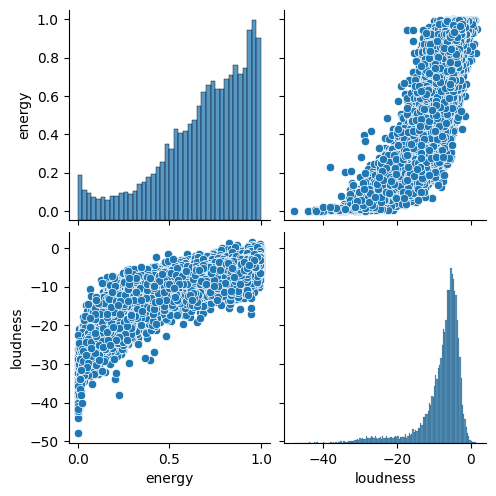

In [10]:
features = ['energy', 'loudness']
data_scatter = sns.pairplot(df[features])
plt.show()

Box plot for features

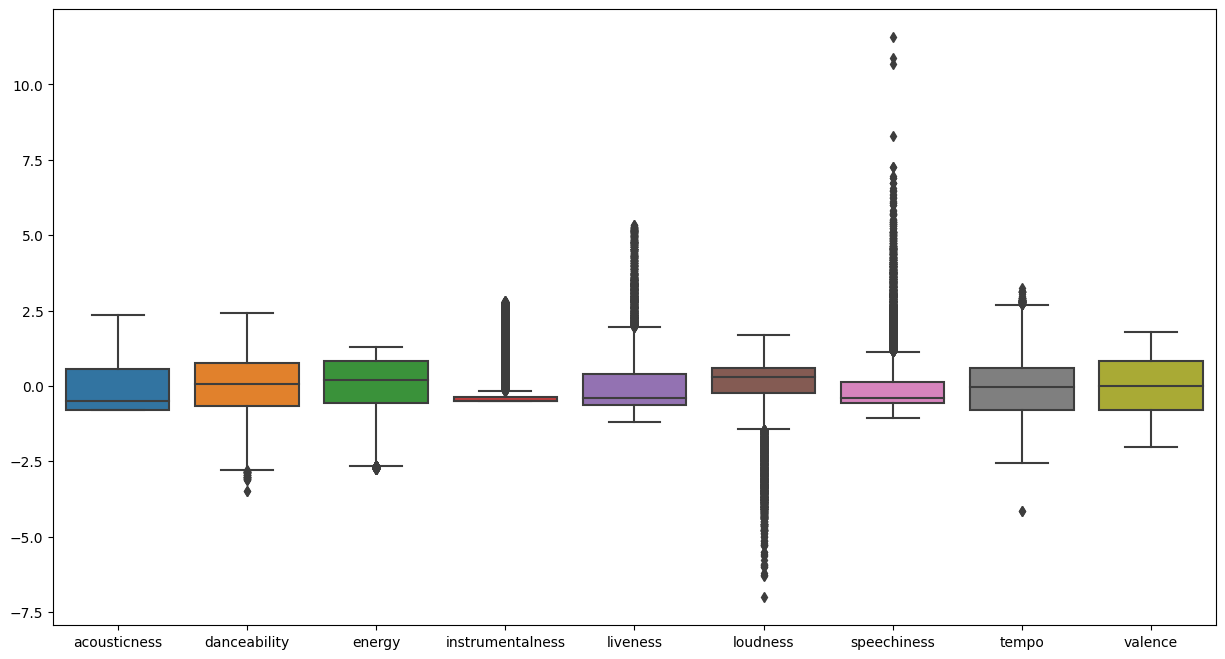

In [4]:

from sklearn.preprocessing import StandardScaler
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, columns=features)
sns.boxplot(data=x)
# Resize plot
plt.gcf().set_size_inches(15, 8)
plt.show()

Apply PCA

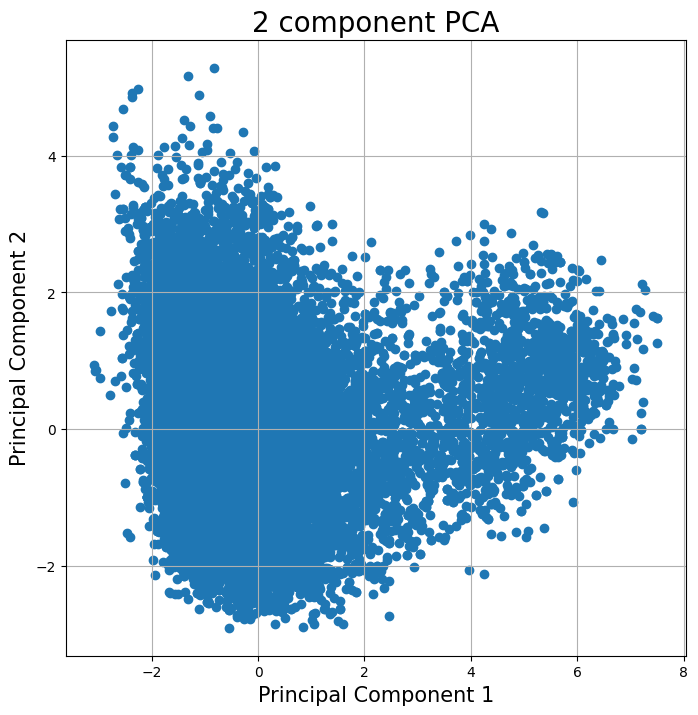

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pca.explained_variance_ratio_

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
ax.grid()